# DEEP LEARNING FACIAL RECOGFNITION MODEL
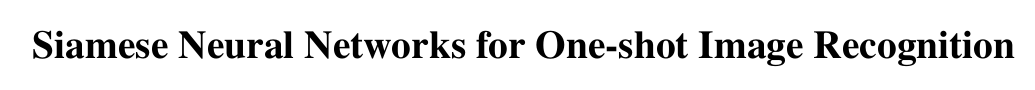

## The Idea:
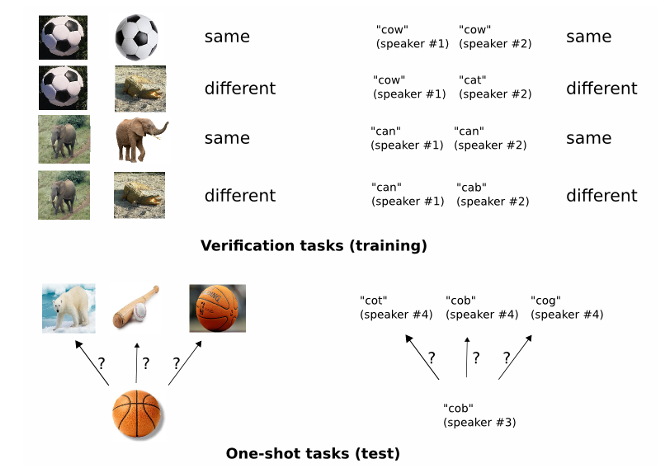

# 1 - Setup

## 1.1 Download Dependencies

In [1]:
# NOTE: un-comment and run code below if first time run it

# !pip install opencv-python matplotlib numpy tensorflow

## 1.2 - Import Dependencies

In [2]:
# Standard dependency
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Tensorflow layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU growth - Avoiding Out of Memory Error

- If using CPU, you can skip this.
- If using GPU, please follow the instruction at https://www.tensorflow.org/install/pip
to setup NVIDA CUDA for Windows WSL2

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

1

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
POS_PATH

'data/positive'

In [8]:
# NOTE: un-comment and run code below if first time run it

# os.makedirs(POS_PATH, exist_ok=True)
# os.makedirs(NEG_PATH, exist_ok=True)
# os.makedirs(ANC_PATH, exist_ok=True)

# 2 - Collect Positives and Anchors

## 2.1 - Untar Labelled Faces in the Wild Dataset
 - Dataset Link: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
 - Un-comment the Code below if running the first time

In [9]:
# # Download the data zip and put it at the root directory for this proj
# # Steps: Unzip -> get all images -> move to /data/negative

# root_dir = os.getcwd()
# zip_path = os.path.join(root_dir, "archive.zip")
# tmp_extract_dir = os.path.join(root_dir, "tmp", "lwf")
# final_data_dir = os.path.join(root_dir, "lwf")

# # Step 0: Create tmp/lwf and data/negative folders
# os.makedirs(tmp_extract_dir, exist_ok=True)
# os.makedirs(final_data_dir, exist_ok=True)

# # Step 1: Unzip to the tmp/lwf folder
# !unzip -q "{zip_path}" -d "{tmp_extract_dir}"

# # Step 2: Move images from nested lfw-deepfunneled folder
# nested_img_dir = os.path.join(tmp_extract_dir, "lfw-deepfunneled", "lfw-deepfunneled")
# !mv "{nested_img_dir}"/* "{final_data_dir}"

# # Step 3: Clean up
# !rm -rf "{tmp_extract_dir}"

In [10]:
# # move images in lfw into negative
# lfw_path = final_data_dir

# for directory in os.listdir(lfw_path):
#     for file in os.listdir(os.path.join(lfw_path, directory)):
#       EX_PATH = os.path.join(lfw_path, directory, file)
#       NEW_PATH = os.path.join(NEG_PATH, file)
#       os.replace(EX_PATH, NEW_PATH)

In [11]:
# !rm -rf "{lfw_path}"

## 2.2 - Collect Positive and Anchor classes
- Because of Tensorflow only support CUDA GPU on WSL, this code cannot use opencv to access camera
- The data was collected and saved in data/positive and data/anchor with normal Window + Tensorflow setup using opencv

# 3 - Load and Preprocess Images

# 3.1 - Get Image Directories

In [103]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

# tf.data.Dataset.list_files helpes create an iterator to loop over each image

In [13]:
print(anchor)

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test)

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7186418d42d0>)


In [16]:
dir_test.next()

b'data/anchor/4e5c5d08-6dda-11f0-934f-346f249a0e35.jpg'

## 3.2 - Preprocess - Scale and Resize

In [17]:
def preprocess(file_path):
    # read image
    byte_img = tf.io.read_file(file_path)
    # load in 
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps: resize to 105x105x3
    img = tf.image.resize(img, (105, 105))  # The reason why 105 is because of the research paper
    # scale imge to be between 0 and 1
    img = img / 255.0
    return img

In [18]:
# example of the preprocess func
img = preprocess("data/anchor/49d96f6e-6dda-11f0-a1fa-346f249a0e35.jpg")

In [19]:
img.numpy().max()

np.float32(0.9888889)

In [20]:
print(img.shape)

(105, 105, 3)


In [21]:
print(img)

tf.Tensor(
[[[0.97376287 0.9227824  0.8874883 ]
  [0.9647059  0.9252101  0.8907563 ]
  [0.9664799  0.92511666 0.8962652 ]
  ...
  [0.7533369  0.6960673  0.67125297]
  [0.72966516 0.6579498  0.64226353]
  [0.6872216  0.614388   0.5900205 ]]

 [[0.976664   0.9259637  0.8898293 ]
  [0.9796119  0.92915165 0.8980392 ]
  [0.9691877  0.9271375  0.8981059 ]
  ...
  [0.6652728  0.61615306 0.5989129 ]
  [0.67392963 0.619868   0.60782313]
  [0.6869881  0.63656795 0.6107843 ]]

 [[0.98394024 0.93333334 0.8880485 ]
  [0.9821662  0.92928505 0.89439774]
  [0.98039216 0.9258637  0.8962652 ]
  ...
  [0.7459717  0.7047774  0.68617666]
  [0.70302784 0.6677337  0.6481259 ]
  [0.6385887  0.6068427  0.58116573]]

 ...

 [[0.50436306 0.44431463 0.44910994]
  [0.4607912  0.39991352 0.41382584]
  [0.4347648  0.37379375 0.40574437]
  ...
  [0.21826284 0.1815682  0.24393979]
  [0.21923433 0.17889823 0.25020006]
  [0.21354984 0.17983195 0.23788625]]

 [[0.42168197 0.37014136 0.40487528]
  [0.39793915 0.34611842 0

## 3.3 - Create Labelled Dataset

There are 2 labels: 1 and 0
- When we feed anchor and positive images, the models should return 1
- When we feed anchor and negative images, the models should return 0

In [22]:
# anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
# positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
# negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [23]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
data

# This data has the shape of ((string), (string), (float32))
# - The first (string): the file path of anchor
# - The second (string): the file path of positive or negative
# - The (float32): the 1 or 0
# => This is our labeled data


<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()
print(example)

(b'data/anchor/4ff26bc2-6dda-11f0-973a-346f249a0e35.jpg', b'data/positive/2b0eb60b-6ddc-11f0-bb61-346f249a0e35.jpg', np.float32(1.0))


## 3.4 - Build Train and Test Partition

In [27]:
def preprocess_twin(input_img, val_img, label):
    return (preprocess(input_img), preprocess(val_img), label)

In [28]:
ex = preprocess_twin(*example)

In [29]:
# plt.imshow(ex[0])
# This should show the image

In [30]:
ex[2]

np.float32(1.0)

In [31]:
# Dataloader Pipeline

# apply the preprocess_twin function for each tuple ((), (), ())
data = data.map(preprocess_twin)
data = data.cache()
# shuffle, so label 1 and 0 are random
data = data.shuffle(buffer_size=1024)

In [32]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

### Training partition

In [33]:
train_data = data.take(round(len(data) * .7))  # .7 means 70%
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


# When training a model, the process usually looks like this:
# -Load a batch of data
# -Preprocess it
# -Feed it to the model
# -Wait for the model to finish training that batch
# -Repeat...

# This can lead to idle time while the model is training, it’s waiting for the next batch to be prepared.

# The Solution: prefetch()
# => prefetch(N) allows the tf.data pipeline to prepare the next N batches in the background 
# while the current batch is being used by the model. 
# This overlaps data preprocessing with model execution, speeding up training.


In [34]:
train_samples = train_data.as_numpy_iterator()

In [35]:
train_sample = train_samples.next()

In [36]:
len(train_sample[0])

16

### Test Partition

In [37]:
test_data = data.skip(round(len(data) * .7))  # .7 means 70%
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4 - Model Engineering

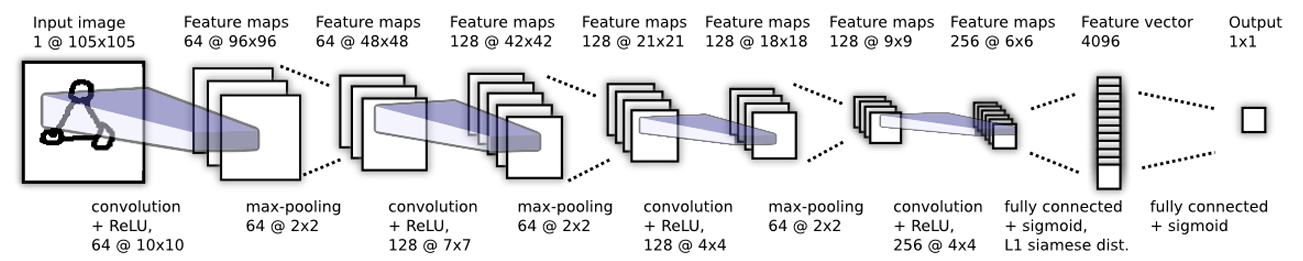

## 4.1 - Build Embedding Layer

In [38]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [39]:
embedding = make_embedding()

In [40]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 - Build Distance Layer

In [41]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, val_embedding):
        return tf.math.abs(input_embedding - val_embedding) 

In [42]:
l1 = L1Dist()

## 4.3 - Make Siamese Model

In [43]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [44]:
siamese_model = make_siamese_model()

In [45]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5 - Training

## 5.1 - Setup Loss and Optimizer

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 - Checkpoints

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

## 5.3 - Build Training Step Function
Training on one batch
- Make a prediction
- Calculate loss
- Derive gradients
- Calculate new weight and apply

In [49]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # get anchor and pos/neg image
        X = batch[:2]
        # get label
        y = batch[2]

        # forward pass
        y_pred = siamese_model(X, training=True)
        # calculate loss
        loss = binary_cross_loss(y, y_pred)

    # Calculate gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate weights and apply
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Building Training Loop

In [50]:
def train(data, EPOCHS):
    # loop through the epochs
    for epoch in range(1, EPOCHS):
        print(f'{epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        # loop through each bath
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)

        # save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 - Train Model

In [51]:
EPOCHS = 50

In [52]:
train(train_data, EPOCHS)

1/50


I0000 00:00:1754015872.327698    3408 cuda_dnn.cc:529] Loaded cuDNN version 90300


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step
2/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2025-07-31 19:38:02.719549: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step
3/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

2025-07-31 19:38:09.569394: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step
4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step
5/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

2025-07-31 19:38:26.017101: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step
6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step
7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step
8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step
9/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step

2025-07-31 19:38:54.595102: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step
10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step
11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step
12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step
13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step
14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step
15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
17/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

2025-07-31 19:39:58.333810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step
18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step
22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step
23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step
24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step
27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step
28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step
29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step
31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step
32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
33/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

2025-07-31 19:42:03.738402: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step
34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step
36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
38/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
39/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step
41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step
42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step
45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step
48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step
49/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step


# 6 - Evaluate Model

In [53]:
from tensorflow.keras.metrics import Precision, Recall

In [85]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [86]:
y_true

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

## 6.1 - Predict for one batch

In [87]:
# Make Prediction
predictions = siamese_model.predict([test_input, test_val])
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


array([[1.0000000e+00],
       [7.2729699e-07],
       [5.6848409e-10],
       [4.5500675e-04],
       [1.0000000e+00],
       [1.6841892e-07],
       [1.8442380e-06],
       [1.2566741e-10],
       [1.0000000e+00],
       [9.9999928e-01],
       [8.2988277e-10],
       [1.0000000e+00],
       [1.1651239e-09],
       [9.9816412e-01],
       [5.6652880e-06],
       [1.0000000e+00]], dtype=float32)

In [88]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in predictions]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]

In [89]:
y_true

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

## 6.2 - Calculate metrics

In [90]:
recall = Recall()

# calculate recall value
recall.update_state(y_true, predictions)
recall.result().numpy()

np.float32(1.0)

In [91]:
recall = Precision()

# calculate Precision value
recall.update_state(y_true, predictions)
recall.result().numpy()

np.float32(1.0)

## 6.3 - Visualize Results

In [95]:
# plt.figure(figsize=(18, 8))
# plt.subplot(1,2,1)
# plt.imshow(test_input[4])
# plt.subplot(1,2,2)
# plt.imshow(test_val[4])
# plt.show()

# 7 - Save Model

In [96]:
siamese_model.save('siamesemodel.h5')

In [98]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                 custom_objects={'L1Dist': L1Dist, 'BinaryCrossentrophy': tf.losses.BinaryCrossentropy})

In [100]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [7.2729699e-07],
       [5.6848409e-10],
       [4.5500675e-04],
       [1.0000000e+00],
       [1.6841892e-07],
       [1.8442380e-06],
       [1.2566741e-10],
       [1.0000000e+00],
       [9.9999928e-01],
       [8.2988277e-10],
       [1.0000000e+00],
       [1.1651239e-09],
       [9.9816412e-01],
       [5.6652880e-06],
       [1.0000000e+00]], dtype=float32)

In [101]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8 - Realtime Test

In [108]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [109]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 - OpenCV Real Time Verification

In [110]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@2339.785] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ERROR:0@2339.793] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range
